## <font color='green'> MNIST - TSNE (Dense Matrix)<font>

### <font color='green'> 1. Description<font>

Decomposition using MNIST Digit Recognition dataset.

Dataset is downloaded from tensorflow by using `tensorflow.keras.datasets.mnist.load_data()` method; so please install tensorflow.

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. In this demo we will use this dataset to correctly cluster similar digits.

### <font color='green'> 2. Data Preprocessing<font>

For MNIST Digits dataset we will perform some data preparation and data cleaning steps.

In [1]:
%%capture
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import metrics
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import OrderedDict

In [2]:
def preprocess_data():
    # Load MNIST Digits dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    x = x.reshape((x.shape[0], -1)).astype('float32')
    x = np.divide(x, 255.)
    return x, y

In [3]:
#---- Data Loading and Preparation ----

X, y = preprocess_data()
X = X[:5000]
y = y[:5000]
n_clusters = len(np.unique(y))
print("Dataset contains {} samples".format(X.shape[0]))
print("Dataset contains {} classes".format(n_clusters))

Dataset contains 5000 samples
Dataset contains 10 classes


### <font color='green'> 3. Algorithm Evaluation<font>

In [4]:
train_time = []
estimator_name = []
cluster_img = []

In [5]:
def get_result_image(Y, labels):
    df = pd.DataFrame({'X':Y[:,0],
                       'Y':Y[:,1],
                       'labels':labels})

    target_ids = range(len(df.labels))

    plt.figure(figsize=(6, 5))
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
    for i, c, label in zip(target_ids, colors, df.labels.unique()):
        plt.scatter(Y[labels == i, 0], Y[labels == i, 1], c=c, label=label) 
    plt.legend()
    plt.show()

In [6]:
def evaluate(estimator, estimator_nm, X, y):
    estimator_name.append(estimator_nm)

    start_time = time.time()
    y_pred = estimator.fit_transform(X)
    train_time.append(round(time.time() - start_time, 4))
    cluster_img.append((y_pred, y))

#### 3.1 TSNE

In [7]:
import frovedis
target = "tsne"
from frovedis.exrpc.server import FrovedisServer
FrovedisServer.initialize("mpirun -np 8 " + os.environ["FROVEDIS_SERVER"])
from frovedis.mllib.manifold import TSNE as frovTSNE
f_est = frovTSNE(n_components=2, method="exact")
e_nm = target + "_exact_frovedis_" + frovedis.__version__
evaluate(f_est, e_nm, X, y)
FrovedisServer.shut_down()

import sklearn
from sklearn.manifold import TSNE as skTSNE
s_est = skTSNE(n_components=2, method="exact")
e_nm = target + "_exact_sklearn_" + sklearn.__version__
evaluate(s_est, e_nm, X, y)

s_est = skTSNE(n_components=2, method="barnes_hut")
e_nm = target + "_barnes_hut_sklearn_" + sklearn.__version__
evaluate(s_est, e_nm, X, y)

### <font color='green'> 4. Performance summary<font>

In [8]:
summary = pd.DataFrame(OrderedDict({ "estimator": estimator_name,
                                     "train time": train_time, 
                                  }))
summary

,estimator,train time
0,tsne_exact_frovedis_0.9.10,2.7745
1,tsne_exact_sklearn_0.24.1,875.0495
2,tsne_barnes_hut_sklearn_0.24.1,7.4585


Frovedis cluster


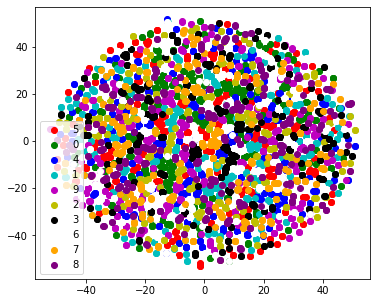

Sklearn cluster


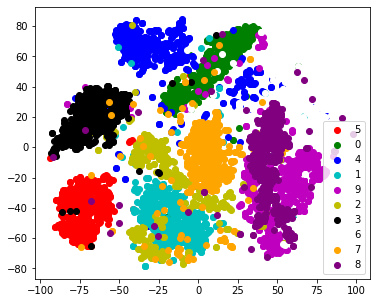

Sklearn Barneshut cluster


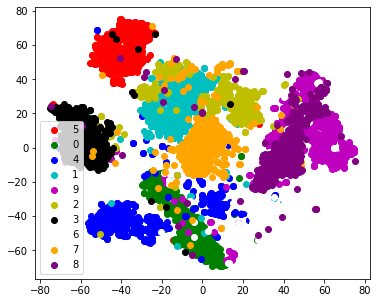

In [9]:
print("Frovedis cluster")
get_result_image(*cluster_img[0])
print("Sklearn cluster")
get_result_image(*cluster_img[1])
print("Sklearn Barneshut cluster")
get_result_image(*cluster_img[2])